In [1]:
# scvelo virtual environment

import scvelo as scv
import numpy as np
import scanpy as sc
import math

In [2]:
import subprocess

# List all installed packages with their versions
def list_installed_packages():
    result = subprocess.run(['pip', 'list'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

# List all installed packages with their versions in requirements format
def freeze_installed_packages():
    result = subprocess.run(['pip', 'freeze'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

# Execute the functions
list_installed_packages()
freeze_installed_packages()


Package             Version
------------------- -------
anndata             0.10.7
appnope             0.1.4
array_api_compat    1.7.1
asttokens           2.4.1
click               8.1.7
comm                0.2.2
contourpy           1.2.1
cycler              0.12.1
debugpy             1.6.7
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
fonttools           4.53.0
get-annotations     0.1.2
h5py                3.11.0
importlib_metadata  7.1.0
importlib_resources 6.4.0
ipykernel           6.29.3
ipython             8.18.1
jedi                0.19.1
joblib              1.4.2
jupyter_client      8.6.2
jupyter_core        5.7.2
kiwisolver          1.4.5
legacy-api-wrap     1.4
llvmlite            0.42.0
loompy              3.0.7
matplotlib          3.9.0
matplotlib-inline   0.1.7
natsort             8.4.0
nest_asyncio        1.6.0
networkx            3.2.1
numba               0.59.1
numpy               1.26.4
numpy-groupies      0.11.1
packaging           24.0


In [3]:
def generate_negative_binomial_matrix(mean_matrix, overdispersion):
    # Ensure overdispersion is positive
    if overdispersion <= 0:
        raise ValueError("Overdispersion parameter must be positive.")
    
    # Calculate the parameters r and p for each element in the matrix
    r_matrix = np.full(mean_matrix.shape, overdispersion)
    p_matrix = r_matrix / (r_matrix + mean_matrix)
    
    # Generate the negative binomial random variables for each element in the matrix
    negative_binomial_matrix = np.random.negative_binomial(r_matrix, p_matrix)
    
    return negative_binomial_matrix

In [4]:
n_obs = 1000
n_vars = 20
t_max = 25
alpha = 4
beta = .2
gamma = .1
noise_level = 2
seed = 520
max_thre = 100
overdispersion = 1 # the larger means the more like a Poisson

# generate S with Gaussian noise
data = scv.datasets.simulation(n_obs=n_obs,
                               n_vars=n_vars,
                               t_max=t_max,
                               alpha=alpha,
                               beta=beta,
                               gamma=gamma,
                               noise_level=noise_level,
                               random_seed=seed)
S = data.layers['spliced']
U = data.layers['unspliced']
data.layers['true_velocity'] = beta*U-gamma*S
S_lam = math.e**(math.log(max_thre)*S/np.max(S)) - 1
U_lam = math.e**(math.log(max_thre)*U/np.max(U)) - 1

np.random.seed(929)
S_poi = generate_negative_binomial_matrix(mean_matrix=S_lam,
                                          overdispersion=overdispersion)
U_poi = generate_negative_binomial_matrix(mean_matrix=U_lam,
                                          overdispersion=overdispersion)
data.layers['spliced'] = S_poi.copy()
data.layers['unspliced'] = U_poi.copy()
data.X = S_poi.copy() # need to make sure X is the same as spliced matrix

In [5]:
# https://github.com/theislab/scvelo/issues/1212

scv.pp.log1p(data)
sc.pp.pca(data)
sc.pp.neighbors(data, n_pcs=30, n_neighbors=30)
scv.pp.moments(data, n_pcs=None, n_neighbors=None)
scv.tl.recover_dynamics(data,t_max=25)
scv.tl.velocity_graph(data,vkey="true_velocity")

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)
    finished (0:00:00) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocity graph (using 1/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:00) --> added 
    'true_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'true_velocity_pca', embedded velocity vectors (adata.obsm)


/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


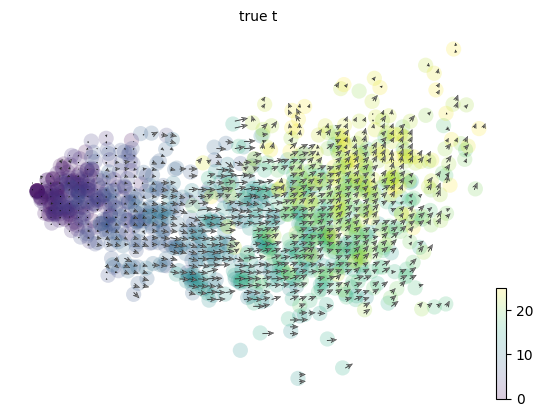

In [6]:
scv.pl.velocity_embedding_grid(data,
                               basis='pca',
                               color="true_t",
                               vkey="true_velocity",
                               arrow_length=2,
                               arrow_size=2,
                               min_mass=10)

/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


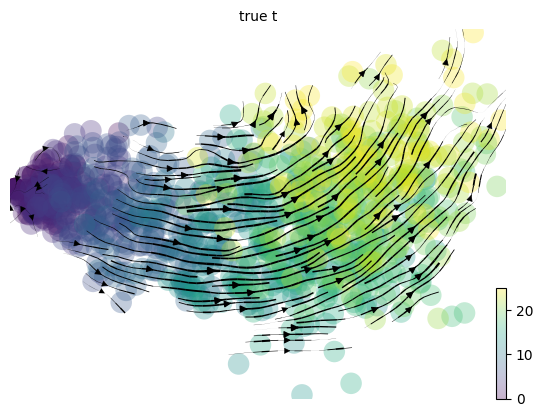

In [7]:
scv.pl.velocity_embedding_stream(data,
                               basis='pca',
                               color="true_t",
                               vkey="true_velocity")

Now for scVelo

In [8]:
data2 = scv.datasets.simulation(n_obs=n_obs,
                               n_vars=n_vars,
                               t_max=t_max,
                               alpha=alpha,
                               beta=beta,
                               gamma=gamma,
                               noise_level=noise_level,
                               random_seed=seed)
S = data2.layers['spliced']
U = data2.layers['unspliced']
S_lam = math.e**(math.log(max_thre)*S/np.max(S)) - 1
U_lam = math.e**(math.log(max_thre)*U/np.max(U)) - 1

np.random.seed(929)
S_poi = generate_negative_binomial_matrix(mean_matrix=S_lam,
                                          overdispersion=overdispersion)
U_poi = generate_negative_binomial_matrix(mean_matrix=U_lam,
                                          overdispersion=overdispersion)
data2.layers['spliced'] = S_poi.copy()
data2.layers['unspliced'] = U_poi.copy()
data2.X = S_poi.copy() # need to make sure X is the same as spliced matrix

In [9]:
data2.X[0:10,0:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [0, 0, 1, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 2, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [0, 1, 0, 0, 0, 4, 0, 0, 0, 0]])

In [10]:
# List of quantiles you want to find
quantiles = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# Find the quantiles of the flattened array
quantile_results = np.quantile(data2.X, quantiles)

print(f"The quantiles {quantiles} of the matrix are: {quantile_results}")

The quantiles [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] of the matrix are: [  0.   0.   0.   0.   0.   1.   1.   3.   5.  11. 239.]


In [11]:
# https://github.com/theislab/scvelo/issues/1212

scv.pp.log1p(data2)
sc.pp.pca(data2)
sc.pp.neighbors(data2, n_pcs=30, n_neighbors=30)
scv.pp.moments(data2, n_pcs=None, n_neighbors=None)

/var/folders/hs/22vv3mms6xbbkl2xk5frsnhc0000gp/T/ipykernel_59072/3518154079.py:3: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(data2)


Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
scv.tl.recover_dynamics(data2)

recovering dynamics (using 1/12 cores)
    finished (0:00:00) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [13]:
scv.tl.velocity(data2, mode='dynamical')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [14]:
scv.tl.velocity_graph(data2)

computing velocity graph (using 1/12 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


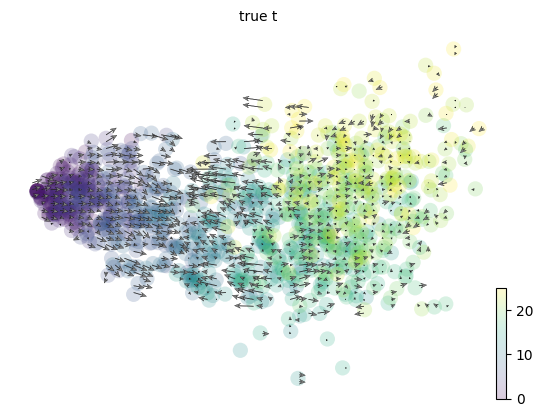

In [15]:
scv.pl.velocity_embedding_grid(data2,
                               basis='pca',
                               color="true_t",
                               arrow_length=2,
                               arrow_size=2,
                               min_mass=10)

/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


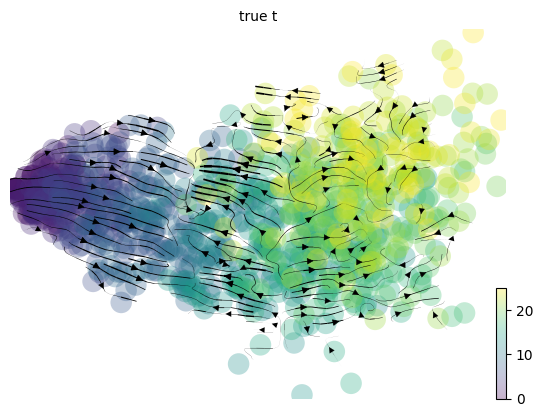

In [16]:
scv.pl.velocity_embedding_stream(data2,
                               basis='pca',
                               color="true_t")

/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/opt/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


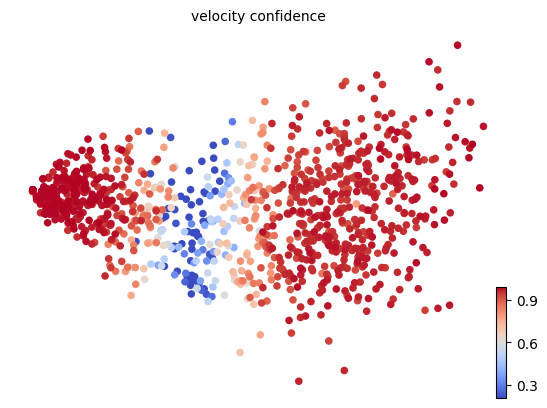

In [17]:
scv.tl.velocity_confidence(data2)
keys = 'velocity_confidence'
scv.pl.scatter(data2, c=keys, cmap='coolwarm', perc=[5, 95])